In [1]:
!pip install openpyxl

You should consider upgrading via the '/Users/javierlopez/.virtualenvs/campeonatofutbol/bin/python -m pip install --upgrade pip' command.


In [2]:
import openpyxl

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from datetime import datetime
from tqdm import tqdm
from scipy.stats import poisson, skellam
from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from poisson_func import * 

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,9) 

## Simulación

In [28]:
new_sim = False
N_sim = 20000


df = pd.read_csv("matches_chile.csv")
df_tabla_2019 = pd.read_csv("Tabla2019.csv", index_col = "Equipo")
df_tabla_2019.sort_values(by=["PTS","DG"], ascending = False, inplace = True)
teams = df.Local.unique()
poisson_model = fit_poisson_model(df)
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Goles   No. Observations:                  536
Model:                            GLM   Df Residuals:                      500
Model Family:                 Poisson   Df Model:                           35
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -745.55
Date:                Sun, 24 Jan 2021   Deviance:                       536.88
Time:                        12:13:42   Pearson chi2:                     449.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0696      0.234      0.297      0.766      -0.389       0.529
Equipo[T.Audax Italiano]                0.1202      0.219      0.548      0.583      -0.309       0.550
Equipo[T.Cobresal]                      0.0024      0.227      0.011      0.991      -0.443       0.448
Equipo[T.Colo-Colo]                    -0.2410      0.242     -0.995      0.320      -0.716       0.234
Equipo[T.Coquimbo Unido]               -0.3635      0.259     -1.403      0.161      -0.871       0.144
Equipo[T.Curicó Unido]                 -0.0688      0.234     -0.294      0.769      -0.528       0.390
Equipo[T.Everton]                      -0.1210      0.232     -0.521      0.602      -0.576       0.334
Equipo[T.Huachipato]                    0.0327      0.223      0.147      0.883      -0.404       0.470
Equipo[T.Iquique]                      -0.1877      0.245     -0.767      0.443      -0.667       0.292
Equipo[T.La Serena]                    -0.2299      0.242     -0.948      0.343      -0.705       0.245
Equipo[T.O'Higgins]                    -0.0256      0.229     -0.112      0.911      -0.474       0.422
Equipo[T.Palestino]                     0.0579      0.223      0.259      0.795      -0.379       0.495
Equipo[T.Santiago Wanderers]           -0.0200      0.227     -0.088      0.930      -0.466       0.426
Equipo[T.Universidad Católica]          0.4454      0.206      2.167      0.030       0.043       0.848
Equipo[T.Universidad de Chile]          0.0863      0.224      0.385      0.700      -0.353       0.526
Equipo[T.Universidad de Concepción]    -0.0839      0.231     -0.364      0.716      -0.536       0.368
Equipo[T.Unión Española]                0.2855      0.214      1.334      0.182      -0.134       0.705
Equipo[T.Unión La Calera]               0.3793      0.209      1.813      0.070      -0.031       0.789
Rival[T.Audax Italiano]                 0.2305      0.217      1.063      0.288      -0.195       0.656
Rival[T.Cobresal]                       0.0010      0.230      0.004      0.997      -0.451       0.452
Rival[T.Colo-Colo]                      0.0775      0.226      0.343      0.732      -0.365       0.520
Rival[T.Coquimbo Unido]                 0.0986      0.230      0.428      0.669      -0.353       0.550
Rival[T.Curicó Unido]                   0.1311      0.226      0.580      0.562      -0.312       0.574
Rival[T.Everton]                       -0.1237      0.235     -0.526      0.599      -0.584       0.337
Rival[T.Huachipato]                     0.0569      0.226      0.252      0.801      -0.386       0.500
Rival[T.Iquique]                        0.1254      0.227      0.552      0.581      -0.320       0.571
Rival[T.La Serena]                     -0.0361      0.234     -0.15

In [5]:
if new_sim == False:
    df_tabla_2020 = pd.read_csv("Tabla2020.csv", index_col = "Equipo")
    sim_poisson_local = pd.read_csv("sim_poisson_local.csv", index_col = [0,1])
    sim_poisson_local.columns = range(1, N_sim + 1)
    sim_poisson_visita = pd.read_csv("sim_poisson_visita.csv", index_col = [0,1])
    sim_poisson_visita.columns = range(1, N_sim + 1)
    df_posicion = pd.read_csv("df_posicion.csv", index_col = 0)
    df_desc_stats = pd.read_csv("df_desc_stats.csv", index_col = 0)
    summary_reasons = pd.read_excel("resumen_descenso.xlsx", index_col = 0)
    df_cd3 = pd.read_csv("df_cd3.csv", index_col = 0)
    df_rel_matches = pd.read_csv("df_rel_matches.csv", index_col = 0)
else:
    np.random.seed(42)
    #plot_poisson_dist(df)
    df_tabla_2020 = current_table(df, teams)
    df_posicion = pd.DataFrame(columns = ['Equipo', 'Tabla', 'n_sim', 'Posición'])

    sim_poisson_local, sim_poisson_visita = poisson_tournament(df, poisson_model, N = N_sim)
    df_posicion = summary_positions(sim_poisson_local, sim_poisson_visita, N_sim, teams, df_tabla_2019,
                                        df_tabla_2020)
    df_desc_stats = relegation_stats(N_sim, df_posicion, poisson_model)
    summary_reasons = create_summary_reasons(df_desc_stats, N_sim)
    df_cd3, df_rel_matches = cases_distribution(df_posicion, N_sim)

## Prob de campeonar

In [6]:
df_posicion[(df_posicion["Posición"] == 1)&(df_posicion.Tabla == "Absoluta")].Equipo.value_counts()/N_sim

Universidad Católica    0.83855
Unión La Calera         0.16090
Unión Española          0.00055
Name: Equipo, dtype: float64

## Prob partido definición Colo Colo vs Universidad de Chile

In [31]:
df_cc_uch = df_rel_matches[(df_rel_matches.team_1.isin(["Colo-Colo","Universidad de Chile"]))&
               (df_rel_matches.team_2.isin(["Colo-Colo","Universidad de Chile"]))]
print("Porcentaje de CC vs UCH:", 100*df_cc_uch.shape[0]/N_sim, "%")
df_cc_uch.head()

Porcentaje de CC vs UCH: 5.665 %


,n_sim,team_1,team_2
52,54,Colo-Colo,Universidad de Chile
60,62,Colo-Colo,Universidad de Chile
61,63,Colo-Colo,Universidad de Chile
62,64,Colo-Colo,Universidad de Chile
63,65,Colo-Colo,Universidad de Chile


## Casos de descenso de UCH

#### Prob UCH último Absoluta

In [8]:
df_ult_abs = df_posicion[(df_posicion.Tabla == "Absoluta")&
            (df_posicion["Posición"] == 18)&
            (df_posicion["Equipo"] == "Universidad de Chile")]
df_ult_abs.shape[0]/N_sim

0.0

In [9]:
df_pen_abs = df_posicion[(df_posicion.Tabla == "Absoluta")&
            (df_posicion["Posición"] == 17)&
            (df_posicion["Equipo"] == "Universidad de Chile")]
df_pen_abs.shape[0]/N_sim

0.0

In [10]:
mod_boolean = False
if mod_boolean == True:
    team = "Universidad de Chile"
    N_matches = 5
    goles_team = 0
    goles_rival = 1
    sim_poisson_local_mod, sim_poisson_visita_mod = sim_poisson_modification(team, N_matches, goles_team, 
                                                                             goles_rival, sim_poisson_local, 
                                                                             sim_poisson_visita)
    df_posicion_mod = summary_positions(sim_poisson_local_mod, sim_poisson_visita_mod, N_sim, teams, 
                                        df_tabla_2019, df_tabla_2020)
    df_desc_stats_mod = relegation_stats(N_sim, df_posicion_mod, poisson_model)
    summary_reasons_mod = summary_reasons(df_desc_stats_mod, N_sim)
    df_cd3_mod, df_rel_matches_mod = cases_distribution(df_posicion_mod, N_sim)

#### Prob UCH último Ponderada

In [11]:
df_ult_pon = df_posicion[(df_posicion.Tabla == "Ponderada")&
            (df_posicion["Posición"] == 18)&
            (df_posicion["Equipo"] == "Universidad de Chile")]
sim_ult_pon = df_ult_pon.n_sim
df_ult_pon.shape[0]/N_sim

0.00035

In [12]:
df_pen_pon = df_posicion[(df_posicion.Tabla == "Ponderada")&
            (df_posicion["Posición"] == 17)&
            (df_posicion["Equipo"] == "Universidad de Chile")]
sim_pen_pon = df_pen_pon.n_sim
df_pen_pon.shape[0]/N_sim

0.013

In [13]:
summary_reasons
# ult TP, ult T2020, liguilla

,1,2,3,Prob Desc
Universidad de Concepción,0.00105,0.79180,0.10940,0.90225
Iquique,0.32040,0.20745,0.29410,0.82195
Coquimbo Unido,0.50425,0.00000,0.09500,0.59925
Colo-Colo,0.14660,0.00000,0.17940,0.32600
La Serena,0.02145,0.00000,0.09915,0.12060
Universidad de Chile,0.00000,0.00075,0.11370,0.11445
Audax Italiano,0.00595,0.00000,0.03635,0.04230
Antofagasta,0.00000,0.00000,0.02815,0.02815
Everton,0.00000,0.00000,0.02475,0.02475
Curicó Unido,0.00000,0.00000,0.01485,0.01485


Probs Abs 0.0 0.0 0.0
Probs Pon 0.00035 0.013 0.4878


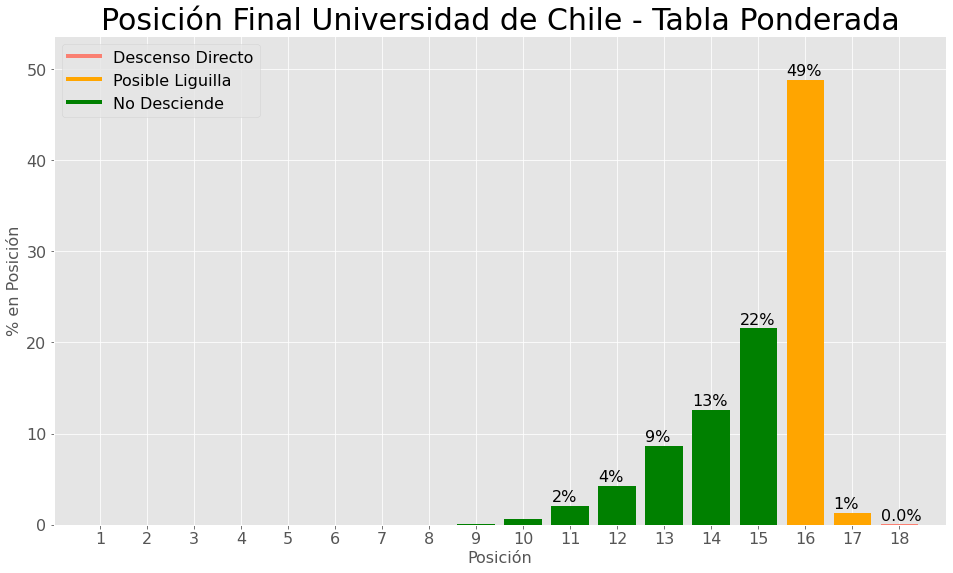

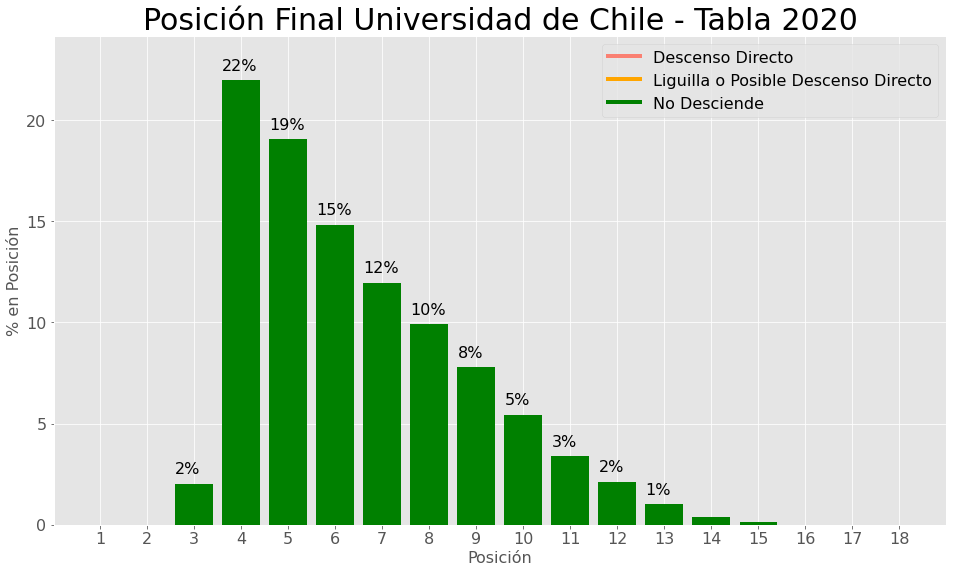

In [14]:
team = "Universidad de Chile"
probs_relegation(team, df_posicion, N_sim)

Probs Abs 0.3204 0.29415 0.18805
Probs Pon 0.44945 0.53495 0.01445


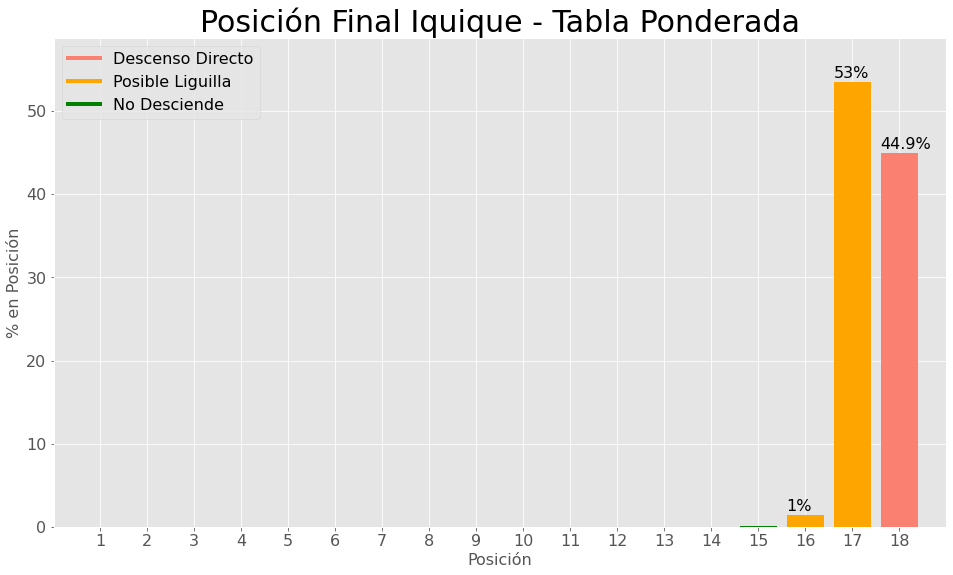

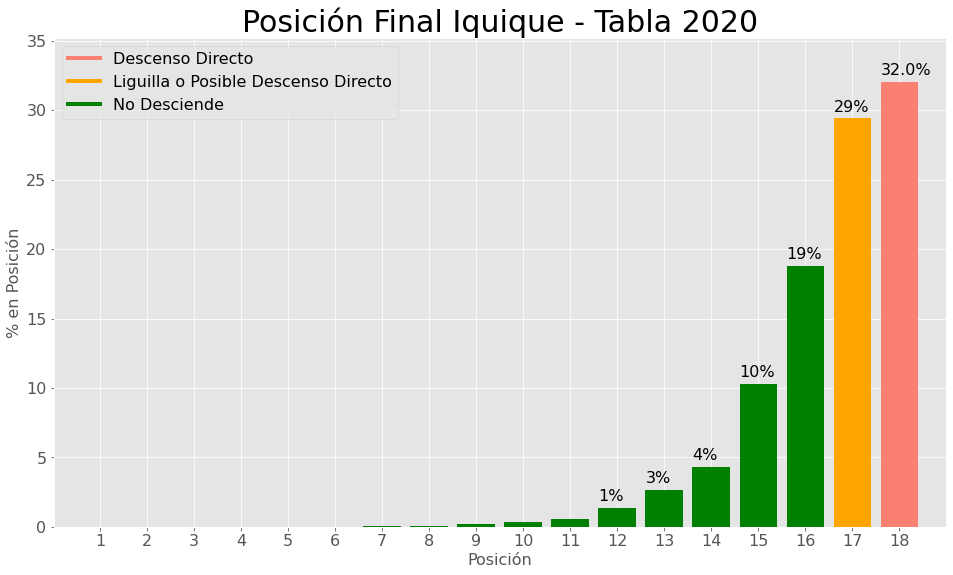

In [15]:
team = "Iquique"
probs_relegation(team, df_posicion, N_sim)

Probs Abs 0.00105 0.014 0.0587
Probs Pon 0.5502 0.44885 0.00095


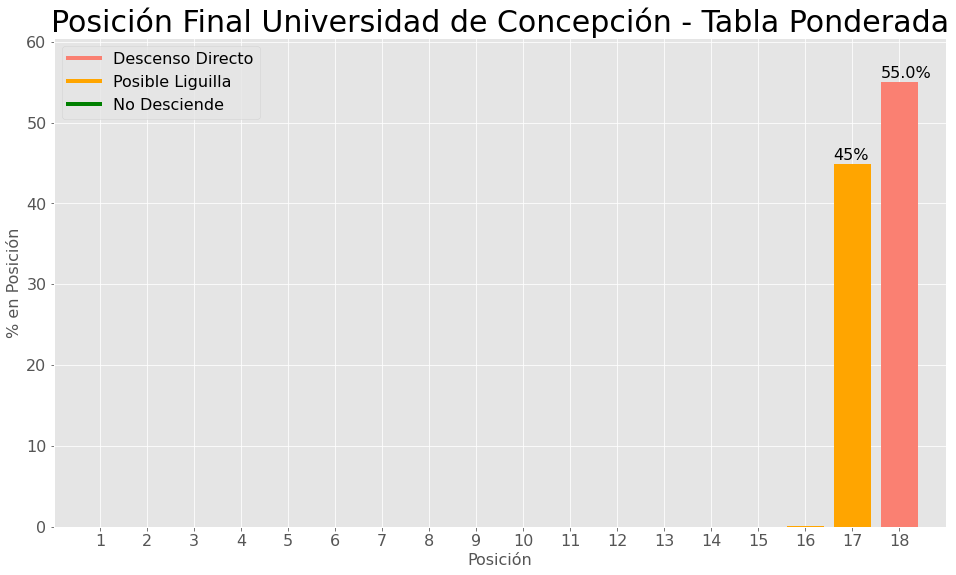

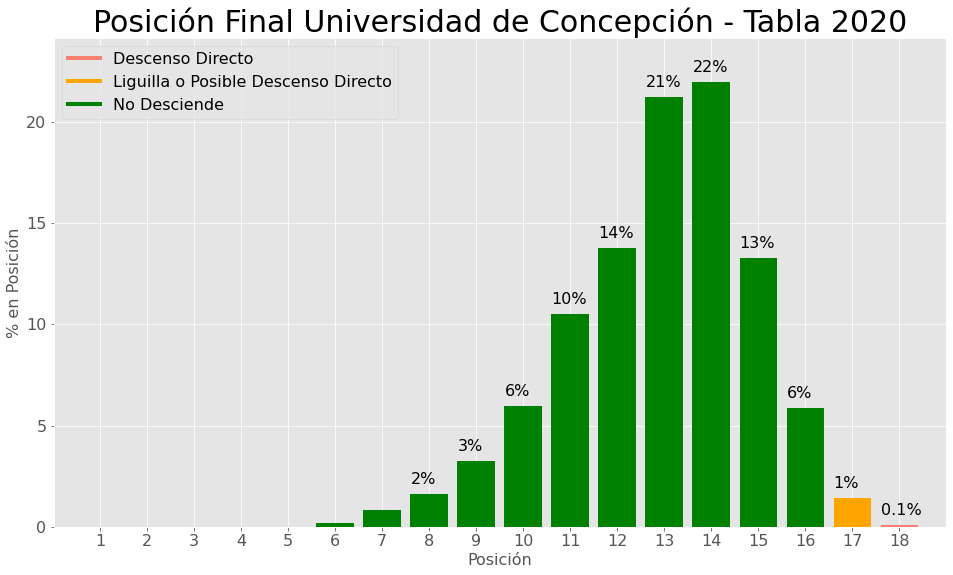

In [16]:
team = "Universidad de Concepción"
probs_relegation(team, df_posicion, N_sim)

Probs Abs 0.1466 0.3036 0.2688
Probs Pon 0.0 0.0 0.0


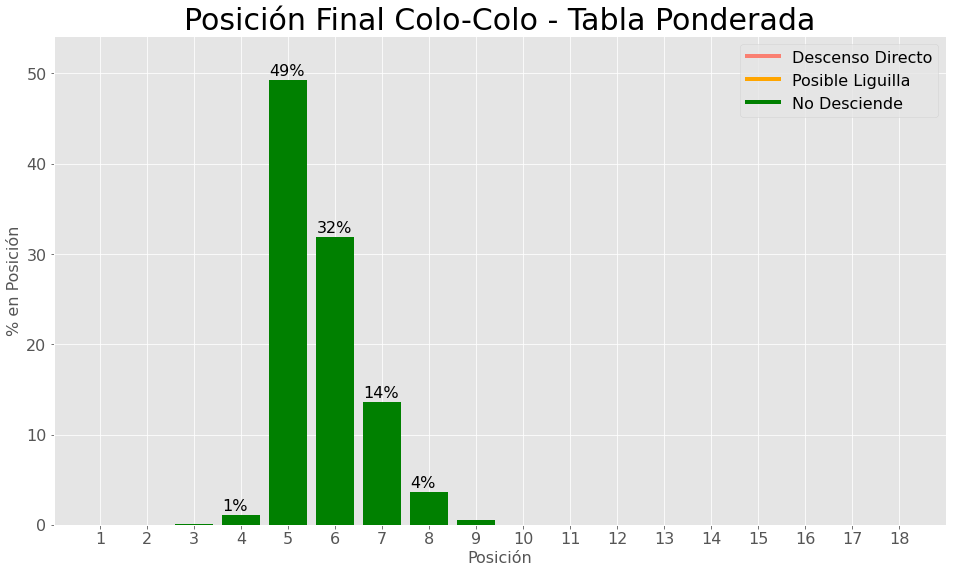

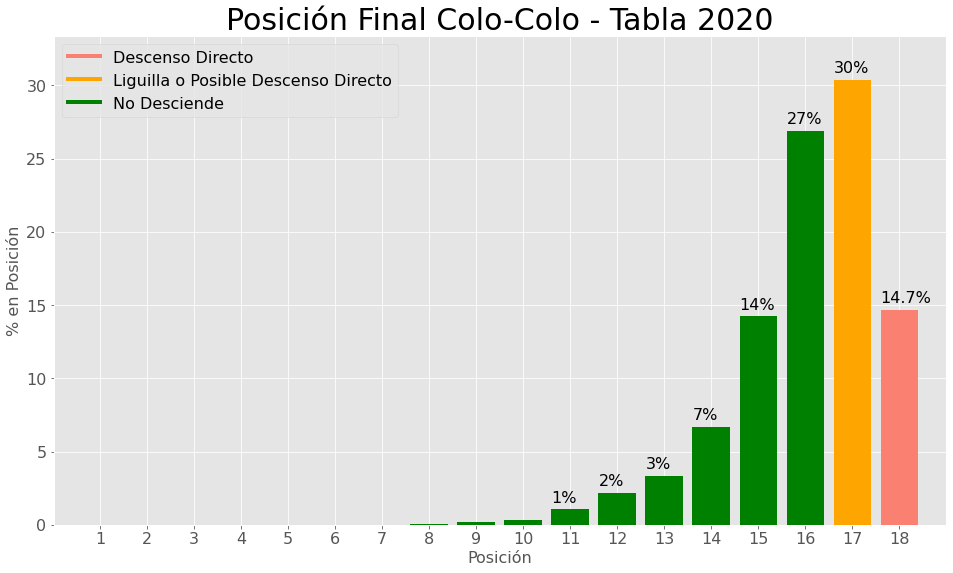

In [17]:
team = "Colo-Colo"
probs_relegation(team, df_posicion, N_sim)

Probs Abs 0.0 0.0 0.0
Probs Pon 0.0 0.0 0.0


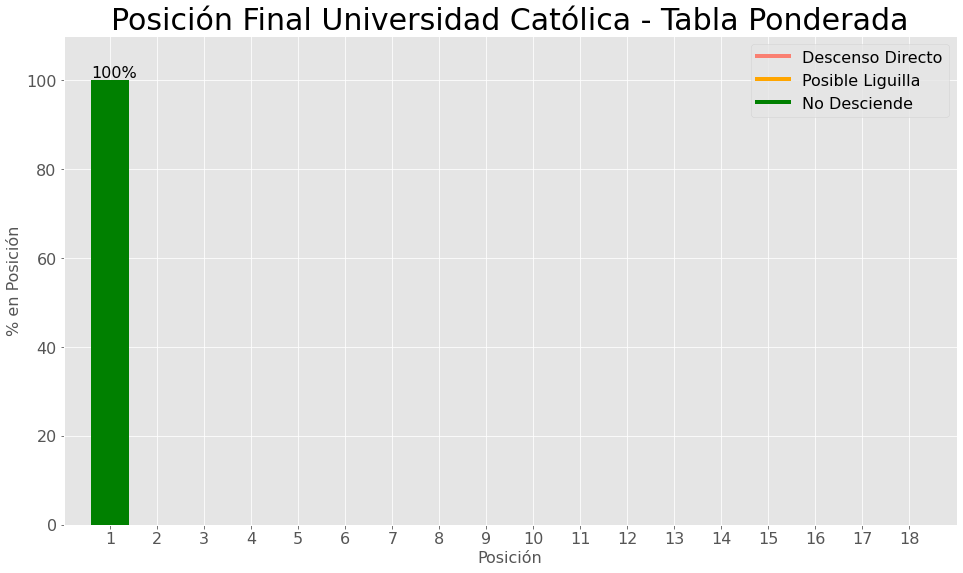

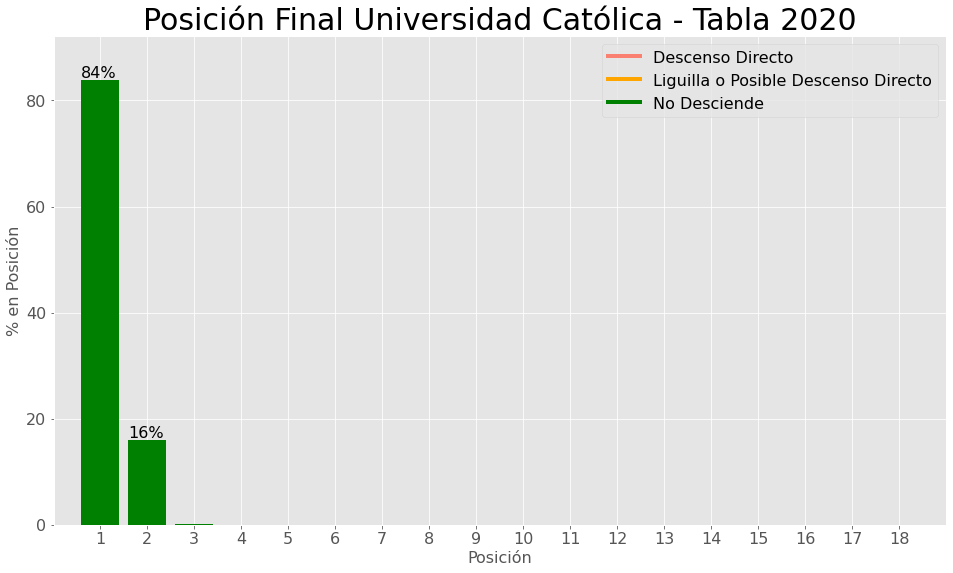

In [19]:
team = "Universidad Católica"
probs_relegation(team, df_posicion, N_sim)

Probs Abs 0.0 0.0 0.0
Probs Pon 0.0 0.0 0.0


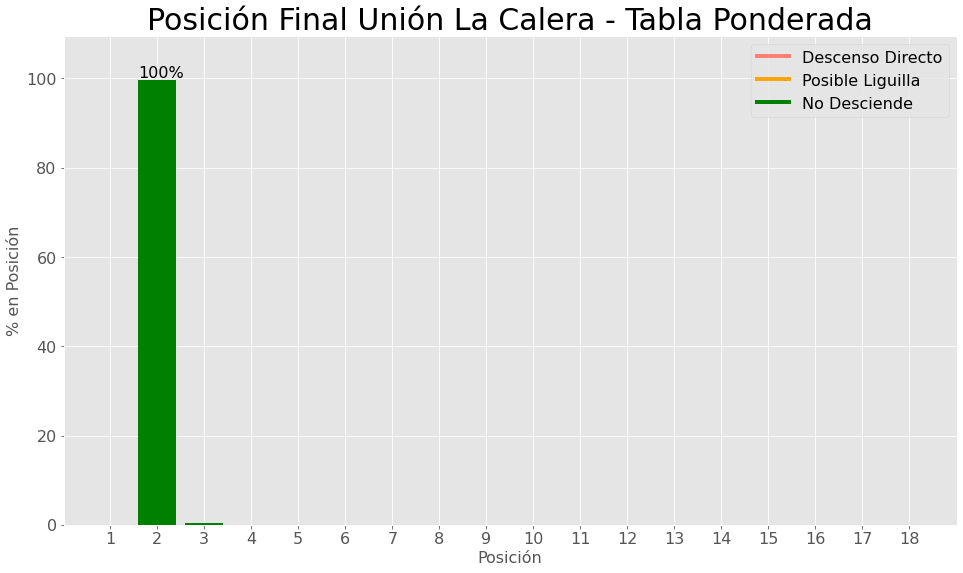

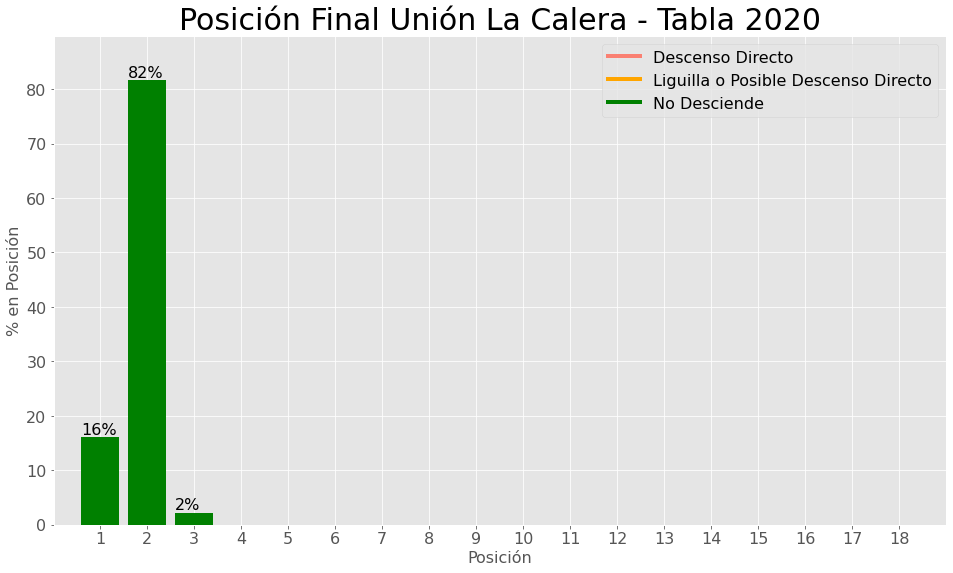

In [21]:
team = "Unión La Calera"
probs_relegation(team, df_posicion, N_sim)

Probs Abs 0.0 0.0 0.0
Probs Pon 0.0 0.0 0.0


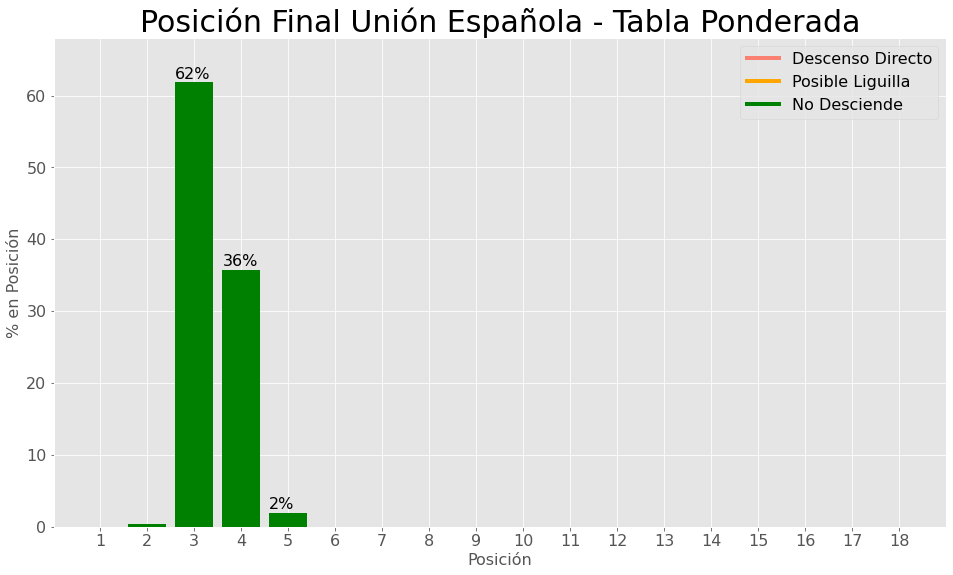

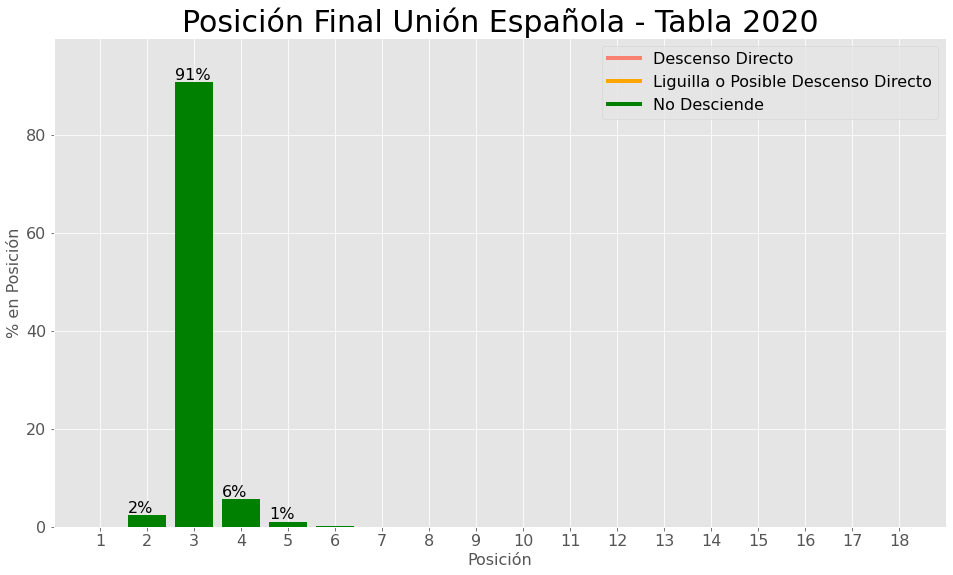

In [24]:
team = "Unión Española"
probs_relegation(team, df_posicion, N_sim)

Probs Abs 0.50425 0.23215 0.11305
Probs Pon 0.0 0.0 0.00055


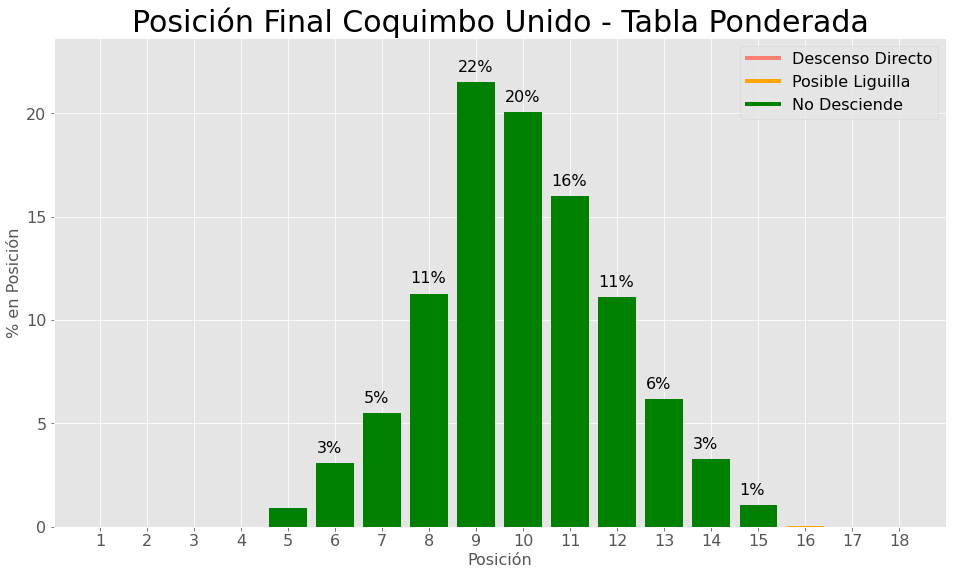

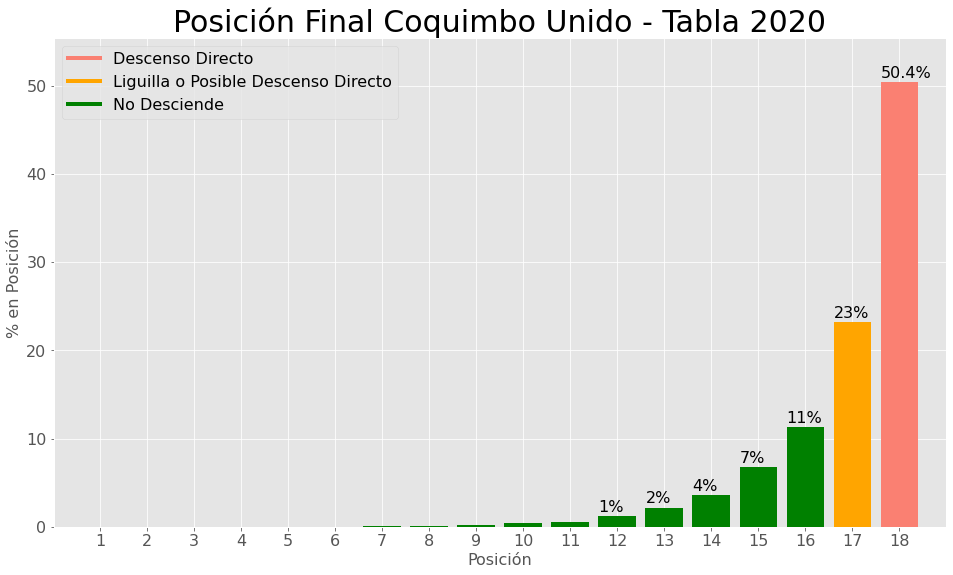

In [25]:
team = "Coquimbo Unido"
probs_relegation(team, df_posicion, N_sim)